In [1]:
# 1번의 기초적인 신경망을 통해서 사진 분류기를 학습함
# 데이터집합은CIFAR-10이며,아래의예와같이10가지의3(R,G,B)채널의32*32크기의사진으로구성됨
# CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함 # 분류기 학습은 다음과 같은 과정을 가짐
# 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함 # 2. 컨볼루션 신경망을 정의함
# 3. 손실함수 정의
# 4. 훈련집합을 이용하여 신경망을 학습시킴 # 5. 테스트집합을 이용하여 신경망 성능 확인
### 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


truck   car truck   car


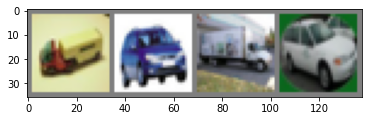

In [5]:
# 훈련집합의 일부 사진들 확인 
import matplotlib.pyplot as plt 
import numpy as np
# functions to show an image 
def imshow(img):
    img = img / 2 + 0.5 # unnormalize 
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images 
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
### 2. 컨볼루션 신경망을 정의함
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 

        return x

net = Net()
### 3. 손실함수 정의, 교차 엔트로피와 SGD+momentum 
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs 
        inputs, labels = data

        # zero the parameter gradients 
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Finished Training')

[1,  1000] loss: 2.294
[1,  2000] loss: 2.098
[1,  3000] loss: 1.930
[1,  4000] loss: 1.767
[1,  5000] loss: 1.707
[1,  6000] loss: 1.623
[1,  7000] loss: 1.604
[1,  8000] loss: 1.559
[1,  9000] loss: 1.517
[1, 10000] loss: 1.518
[1, 11000] loss: 1.486
[1, 12000] loss: 1.468
[2,  1000] loss: 1.406
[2,  2000] loss: 1.404
[2,  3000] loss: 1.377
[2,  4000] loss: 1.394
[2,  5000] loss: 1.349
[2,  6000] loss: 1.344
[2,  7000] loss: 1.356
[2,  8000] loss: 1.320
[2,  9000] loss: 1.331
[2, 10000] loss: 1.316
[2, 11000] loss: 1.283
[2, 12000] loss: 1.282
Finished Training


GroundTruth:    cat  ship  ship plane


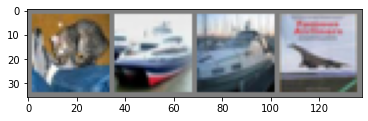

In [10]:
### 5. 테스트집합을 이용하여 신경망 성능 확인 
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


In [12]:
# performance on the whole test dataset 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [13]:
# performance on each class 
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10)) 
with torch.no_grad():
    for data in testloader: 
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) 
        c = (predicted == labels).squeeze() 
        for i in range(4):
            label = labels[i] 
            class_correct[label] += c[i].item() 
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 68 %
Accuracy of  bird : 51 %
Accuracy of   cat : 23 %
Accuracy of  deer : 27 %
Accuracy of   dog : 62 %
Accuracy of  frog : 74 %
Accuracy of horse : 53 %
Accuracy of  ship : 68 %
Accuracy of truck : 54 %
